# Text Classification: Classify Faculty from Chula courses description

## Import libraries and Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
## Uncomment if used in Google Colab
!git init .
!git remote add origin https://github.com/new5558/Chula-course-recommender-proof-of-concept
!git pull origin master
!pip install -r requirements.txt

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/new5558/Chula-course-recommender-proof-of-concept
 * branch            master     -> FETCH_HEAD
   d71a027..2644f2c  master     -> origin/master
Updating d71a027..2644f2c
Fast-forward
 src/model.ipynb | 14924 ++++++++++++++++++++++++++++--------------------------
 1 file changed, 7694 insertions(+), 7230 deletions(-)


In [3]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import multiprocessing as mp
import skopt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [4]:
import os
os.getcwd()

'/content'

In [5]:
dtype_dic= {'course_no': str, 'program_code': str}

courses_df = pd.read_csv('./data/course_chula_full.csv', index_col=0)
program_courses_thai_df = pd.read_csv('./data/program_courses_thai.csv', dtype=dtype_dic, index_col=0)

In [6]:
courses_df

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,2000503,Research Ethics,RESEARCH ETHICS,Definition of research and research ethics; da...,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...
1,2000504,Social Change Initiative Implementation,SOC CHG IMP,Principle on social change initiative towards ...,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...
2,2000601,CORPORATE GOVERNANCE,CORP GOVERNANCE,-,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...
3,2000611,Study Abroad I,STUDY ABROAD I,Study additional courses abroad according to t...,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...
4,2000612,Study Abroad II,STUDY ABROAD II,Study additional courses abroad according to t...,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...
...,...,...,...,...,...,...
25249,JDBA931,READING AND CONFERENCES IN TERNATIONAL BUSINESS,-,Advanced or specialized topics in internationa...,-,-
25250,JDBA936,DISSERTATION,-,This course is for the doctoral students who a...,-,-
25251,JDBA941,READING AND CONFERENCES IN MARKETING,-,Advanced or specialized topics in marketing wh...,-,-
25252,JDBA946,DISSERTATION,-,This course is for the doctoral students who a...,-,-


In [7]:
program_courses_thai_df

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
1,กลุ่มวิชาภาษาต่างประเทศ,5501123,121001
2,กลุ่มวิชาภาษาต่างประเทศ,5501214,121001
3,กลุ่มวิชาภาษาต่างประเทศ,5501225,121001
4,กลุ่มวิชาศึกษาทั่วไปกลุ่มพิเศษ,2140111,121001
...,...,...,...
25570,วิทยานิพนธ์,6302828,563001
25573,รายวิชาบังคับเลือก,6302601,563001
25574,รายวิชาบังคับเลือก,6302602,563001
25575,รายวิชาบังคับเลือก,6302603,563001


## Data Exploration

In [8]:
program_courses_thai_df['course_no'].apply(lambda x: len(str(x))).value_counts()

7    20607
Name: course_no, dtype: int64

In [9]:
program_courses_thai_df.dtypes

tag             object
course_no       object
program_code    object
dtype: object

In [10]:
courses_df.dtypes

course_no              object
course_name            object
course_abberviation    object
description            object
course_name_thai       object
description_thai       object
dtype: object

In [11]:
def detect_language(text):
  if text == '-':
    return text
  try:
    return detect(text)
  except:
    return 'err'

In [12]:
p = mp.Pool(mp.cpu_count())
description_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['description_thai']), total = len(courses_df))), name="description_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [13]:
description_thai_language.value_counts()

th    22880
-      2360
de       11
en        3
Name: description_thai, dtype: int64

In [14]:
courses_df[(description_thai_language != 'th') & (description_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
286,2007894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
324,2008896,Comprehensive Examination,COMPREHENSIVE EXAM,S/U,การสอบประมวลความรู้,S/U
417,2010897,QUALIFYING EXAMINATION,QUALIFYING EXAM,การสอบวัดคุณสมบัติ,การสอบวัดคุณสมบัติ,QUALIFYING EXAMINATION
446,2013811,THESIS,THESIS,-,วิทยานิพนธ์,S/U
2431,2109520,PHYSICAL CERAMICS,PHY CERAMICS,Physical and chemical process responsible for ...,เซรามิกกายภาพ,Physical and chemical process responsible for ...
4837,2208896,COMPREHENSIVE EXAMINATION,COM EXAM,S/U,สอบประมวลความรู้,S/U
5820,2231841,SEMINAR IN FRENCH LANGUAGE AND LITERATURE I,SEM FR LANG LIT I,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 1,S/U
5821,2231842,SEMINAR IN FRENCH LANGUAGE AND LITERATURE II,SEM FE LAND LIT II,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 2,S/U
5822,2231894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
10417,2600896,COMPREHENSIVE EXAMINIATION,COMPREHENSIVE EXAM,(S/U),การสอบประมวลความรู้,S/U


In [15]:
courses_df.iloc[17405]['description_thai']

'ปฏิบัติงานฝึกทำผ่าตัดที่ยากขึ้น เช่น transurethral resection of prostate, reconstructive surgery อย่างง่าย เช่น pyeloplasty, urethroplasty, vasovasostomy, urinary diversion, radialsurgery อย่างง่าย เช่น radical nephrectomy, radical orchiectomy'

In [16]:
p = mp.Pool(mp.cpu_count())
course_name_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['course_name_thai']), total = len(courses_df))), name="course_name_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [17]:
course_name_thai_language.value_counts()

th    24589
-       663
en        2
Name: course_name_thai, dtype: int64

In [18]:
courses_df[(course_name_thai_language != 'th') & (course_name_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
666,2023505,ENGY CONSERV IND,การอนุรักษ์พลังงานในภาคอุตสาหกรรม,Principles and process of energy conservation ...,Energy Conservation in Industry,หลักการและกระบวนการในการดำเนินการอนุรักษ์พลังง...
21649,3341711,PHARMACEUTICAL CHEMISTRY AND NATURAL PRODUCTS ...,-,Oral presentation and discussion of selected a...,PH CHM NAT SEM II,-


## Clean Data

In [19]:
courses_df_clean = courses_df[((description_thai_language == 'th') & (course_name_thai_language == 'th'))]

In [20]:
courses_df_clean

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,2000503,Research Ethics,RESEARCH ETHICS,Definition of research and research ethics; da...,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...
1,2000504,Social Change Initiative Implementation,SOC CHG IMP,Principle on social change initiative towards ...,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...
2,2000601,CORPORATE GOVERNANCE,CORP GOVERNANCE,-,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...
3,2000611,Study Abroad I,STUDY ABROAD I,Study additional courses abroad according to t...,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...
4,2000612,Study Abroad II,STUDY ABROAD II,Study additional courses abroad according to t...,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...
...,...,...,...,...,...,...
25191,6800682,Doctoral Seminar II,DOC SEMINAR II,Seminar for consideration of issues related to...,สัมมนาปริญญาเอก 2,สัมมนาประเด็นที่สัมพันธ์กับวิทยานิพนธ์
25201,6800810,Special Project,SPEC PROJECT,For those who have not botained an MPH degree ...,โครงการพิเศษ,สำหรับผู้ที่ยังไม่ได้รับปริญญาสาธารณสุขศาสตรมห...
25206,857701,SEMINAR I,-,Serminar on current research in petrochemical ...,สัมมนา 1,การประชุมทางวิชาการเพื่อเสนอและวิจารณ์ผลงานทาง...
25207,857702,SEMINAR II,-,Seminar on current research in petrochemical t...,สัมมนา 2,การประชุมทางวิชาการเพื่อเสนอและวิจารณ์ผลงานทาง...


## Data transformation

In [21]:
df_faculty = courses_df_clean[['course_no', 'course_name_thai', 'description_thai']]

In [22]:
course_no_len = df_faculty['course_no'].apply(lambda x: len(x))

In [23]:
course_no_len.value_counts()

7    22831
6       44
4        1
Name: course_no, dtype: int64

In [24]:
df_faculty[course_no_len == 6]

,course_no,course_name_thai,description_thai
208,200614,การจัดการบริการผู้โดยสาร,การบริการผู้โดยสาร การบริการในห้องรับรองผู้โดย...
636,202169,เคมีสำหรับนิสิตแพทย์,เทอร์โมไดนามิกส์ สมดุลเคมี จลนพลศาสตร์เคมี โคร...
1636,210443,ออโตเมชัน,แนวคิดพื้นฐานเกี่ยวกับระบบออโตเมชันในอุตสาหกรร...
1897,210564,วิศวกรรมของวัสดุที่ย่อยสลายได้ทางชีวภาพ,ประเภทของวัสดุที่ย่อยสลายได้ทางชีวภาพทั้งวัสดุ...
2236,210794,การผลิตน้ำใช้และการบำบัดน้ำเสียในอุตสาหกรรม,แหล่งของน้ำใช้ มาตรฐานของน้ำในอุตสาหกรรมเทคนิค...
2929,213225,ปฏิบัติการวัดความดำ,ปฏิบัติการเกี่ยวกับการวัดแสง การวัดความดำ การ...
3308,218220,วิธีเชิงคณิตศาสตร์ขั้นสูง,การวิเคราะห์เชิงซ้อนซึ่งประกอบด้วยฟังก์ชันของต...
3318,218228,สิ่งประดิษฐ์สารกึ่งตัวนำ 1,สมบัติของผลึกและการปลูกผลึกสารกึ่งตัวนำ อะตอมแ...
3332,218244,อิเล็กทรอนิกส์ชีวแพทย์,สัญญาณไฟฟ้าในร่างกายมนุษย์ ศักย์กระทำในเซลล์ อ...
3345,218248,สิ่งประดิษฐ์สารกึ่งตัวนำ 2,การทบทวนฟิสิกส์และสมบัติของสารกึ่งตัวนำ สารประ...


In [25]:
df_faculty = df_faculty[course_no_len == 7]

In [26]:
faculty_no = df_faculty['course_no'].apply(lambda x: x[:2])
faculty_no

0        20
1        20
2        20
3        20
4        20
         ..
25188    68
25189    68
25190    68
25191    68
25201    68
Name: course_no, Length: 22831, dtype: object

In [27]:
faculty_no_counts = faculty_no.value_counts()
faculty_no_counts

30    2652
22    2614
21    2453
27    2407
23    2039
33    1015
32    1010
28     991
31     941
26     907
25     844
24     638
20     605
37     577
34     525
38     507
29     496
39     463
35     397
36     232
53     118
55     118
63      98
51      80
40      59
68      28
56      13
65       1
48       1
58       1
60       1
Name: course_no, dtype: int64

In [28]:
faculty_more_than_50 = faculty_no_counts[faculty_no_counts > 50].index
faculty_more_than_50

Index(['30', '22', '21', '27', '23', '33', '32', '28', '31', '26', '25', '24',
       '20', '37', '34', '38', '29', '39', '35', '36', '53', '55', '63', '51',
       '40'],
      dtype='object')

In [29]:
df_faculty['faculty_no'] = faculty_no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df_faculty = df_faculty[df_faculty['faculty_no'].isin(faculty_more_than_50)]

In [31]:
df_faculty

,course_no,course_name_thai,description_thai,faculty_no
0,2000503,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...,20
1,2000504,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...,20
2,2000601,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...,20
3,2000611,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
4,2000612,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
...,...,...,...,...
25154,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25155,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63
25156,6303624,การเพิ่มประสิทธิภาพการเก็บกู้น้ำมัน,หลักการของการเพิ่มการเก็บกู้น้ำมัน คุณสมบัติขอ...,63
25157,6303625,การบริหารโครงการ,เนื้อหาวิชาครอบคลุมภาคทฤษฎีและภาคปฏิบัติของการ...,63


In [32]:
df = df_faculty

## Prepare data for each models

### Commons

In [33]:
from skopt.callbacks import CheckpointSaver
import time


class BayesianCallback(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")

# Backward compatible reason
class LifeSaver(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")


In [34]:
Y_text = df['faculty_no'].values
Y_text

array(['20', '20', '20', ..., '63', '63', '63'], dtype=object)

In [35]:
program_courses_thai_df[program_courses_thai_df['course_no'] == '5501112']

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
67,กลุ่มวิชาภาษาต่างประเทศ,5501112,121002
135,กลุ่มวิชาภาษาต่างประเทศ,5501112,121003
191,กลุ่มวิชาภาษาต่างประเทศ,5501112,121004


In [36]:
import math

def get_program_from_course_no(course_no):
    result = program_courses_thai_df[program_courses_thai_df['course_no'] == course_no]['program_code'].drop_duplicates().values
    return result if len(result) != 0 else math.nan

In [37]:
Y_program = None

with mp.Pool(mp.cpu_count()) as p:
  Y_program = pd.Series(list(tqdm(p.imap(get_program_from_course_no, df['course_no']), total = len(df))))

  0%|          | 0/22786 [00:00<?, ?it/s]

In [38]:
Y_program = Y_program.dropna()

In [39]:
Y_program

39       [320030, 520031]
40       [320030, 520031]
41               [320030]
42               [320030]
43               [320030]
               ...       
22781            [363200]
22782            [363200]
22783            [363200]
22784            [363200]
22785            [363200]
Length: 11549, dtype: object

### Tokenize word

In [40]:
from pythainlp import word_tokenize

print("no whitespace:", word_tokenize(df['description_thai'].iloc[0], keep_whitespace=False))

no whitespace: ['ความหมาย', 'ของ', 'งานวิจัย', 'และ', 'จริยธรรม', 'การวิจัย', 'การ', 'ได้มา', 'ซึ่ง', 'ข้อมูล', 'และ', 'การ', 'จัดการ', 'ข้อมูล', 'การ', 'เป็นเจ้าของ', 'งานประพันธ์', 'และ', 'การ', 'ตีพิมพ์', 'การ', 'ประพฤติ', 'ผิดทาง', 'การวิจัย', 'การ', 'ใช้', 'สัตว์', 'ทด', 'ลองใน', 'งานวิจัย', 'การ', 'เป็น', 'พี่เลี้ยง', 'ใน', 'งานวิจัย', 'และ', 'งานวิจัย', 'ร่วม', 'ภาวะ', 'ส่วนตัว', 'การ', 'ถือเป็นความลับ', 'เฉพาะ', 'และ', 'ผลประโยชน์', 'ขัดกัน', 'กระบวนการ', 'ตรวจสอบ', 'การ', 'ประพฤติ', 'ฝึก', 'ทาง', 'จริยธรรม', 'การวิจัย', 'ของ', 'จุฬาลงกรณ์', 'มหาวิทยาลัย']


In [41]:
description_thai_tokenize = df['description_thai'].progress_apply(lambda x: word_tokenize(x, keep_whitespace=False))
description_thai_tokenize

  0%|          | 0/22786 [00:00<?, ?it/s]

0        [ความหมาย, ของ, งานวิจัย, และ, จริยธรรม, การวิ...
1        [หลักการ, การ, ริเริ่ม, การเปลี่ยนแปลง, ของ, ส...
2        [ภาพรวม, ของ, กิจการ, ภิ, บาล, ปัญหา, และ, ต้น...
3        [การศึกษา, รายวิชา, เพิ่มเติม, ใน, ต่างประเทศ,...
4        [การศึกษา, รายวิชา, เพิ่มเติม, ใน, ต่างประเทศ,...
                               ...                        
25154    [การ, อภิปราย, หัวข้อ, พิเศษ, ที่, เกี่ยวข้อง,...
25155    [เนื้อหาวิชา, ครอบคลุม, พัฒนาการ, และ, ความเปล...
25156    [หลักการ, ของ, การ, เพิ่ม, การ, เก็บ, กู้, น้ำ...
25157    [เนื้อหาวิชา, ครอบคลุม, ภาคทฤษฎี, และ, ภาคปฏิบ...
25158    [การวิจัย, ใน, เทคโนโลยี, ปิโตรเลียม, เพื่อ, ค...
Name: description_thai, Length: 22786, dtype: object

In [42]:
description_thai_word_count = description_thai_tokenize.apply(lambda x: len(x))

In [43]:
description_thai_word_count.value_counts()

22     522
24     516
32     496
25     496
33     494
      ... 
203      1
175      1
305      1
177      1
255      1
Name: description_thai, Length: 190, dtype: int64

In [44]:
print(description_thai_word_count.mean())
print(description_thai_word_count.median())
print(description_thai_word_count.max())
print(description_thai_word_count.min())

38.33823400333538
34.0
305
1


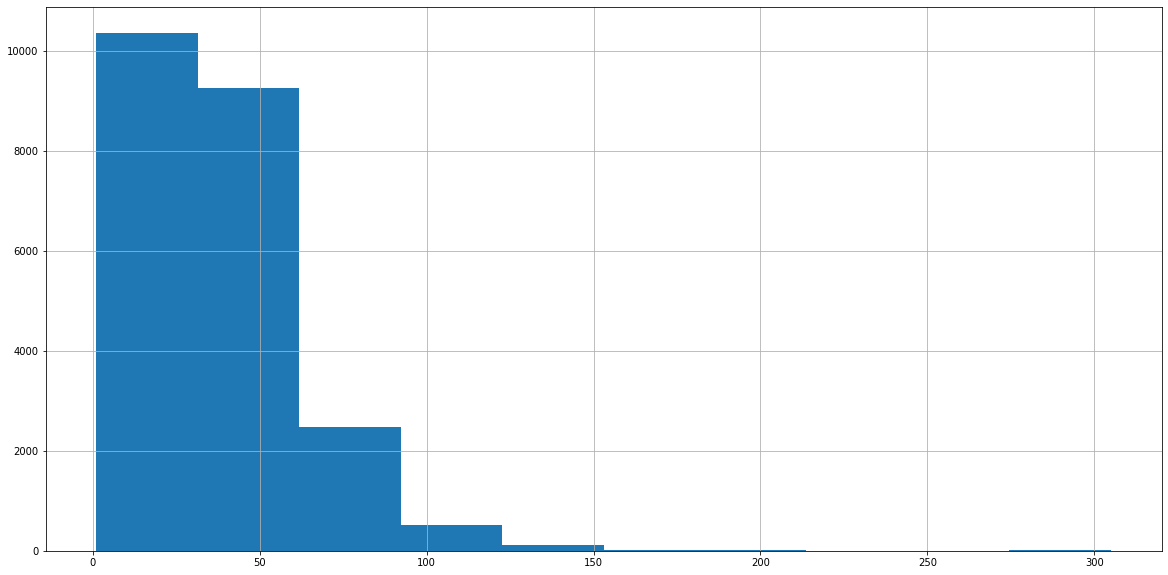

In [45]:
description_thai_word_count.hist(figsize = (20, 10))

In [46]:
description_thai_tokenize

0        [ความหมาย, ของ, งานวิจัย, และ, จริยธรรม, การวิ...
1        [หลักการ, การ, ริเริ่ม, การเปลี่ยนแปลง, ของ, ส...
2        [ภาพรวม, ของ, กิจการ, ภิ, บาล, ปัญหา, และ, ต้น...
3        [การศึกษา, รายวิชา, เพิ่มเติม, ใน, ต่างประเทศ,...
4        [การศึกษา, รายวิชา, เพิ่มเติม, ใน, ต่างประเทศ,...
                               ...                        
25154    [การ, อภิปราย, หัวข้อ, พิเศษ, ที่, เกี่ยวข้อง,...
25155    [เนื้อหาวิชา, ครอบคลุม, พัฒนาการ, และ, ความเปล...
25156    [หลักการ, ของ, การ, เพิ่ม, การ, เก็บ, กู้, น้ำ...
25157    [เนื้อหาวิชา, ครอบคลุม, ภาคทฤษฎี, และ, ภาคปฏิบ...
25158    [การวิจัย, ใน, เทคโนโลยี, ปิโตรเลียม, เพื่อ, ค...
Name: description_thai, Length: 22786, dtype: object

In [47]:
X_text = description_thai_tokenize.to_list()

### Thai2Fit - predict faculty

In [ ]:
df

,course_no,course_name_thai,description_thai,faculty_no
0,2000503,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...,20
1,2000504,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...,20
2,2000601,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...,20
3,2000611,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
4,2000612,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
...,...,...,...,...
25154,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25155,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63
25156,6303624,การเพิ่มประสิทธิภาพการเก็บกู้น้ำมัน,หลักการของการเพิ่มการเก็บกู้น้ำมัน คุณสมบัติขอ...,63
25157,6303625,การบริหารโครงการ,เนื้อหาวิชาครอบคลุมภาคทฤษฎีและภาคปฏิบัติของการ...,63


In [ ]:
# Example
from pythainlp.word_vector import sentence_vectorizer

sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
example_vector = sentence_vectorizer(sentence, use_mean=True)
print(example_vector.shape)

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


100%|██████████| 62452646/62452646 [00:00<00:00, 156022399.80it/s]


(1, 300)


In [ ]:
def doc2vec(text): 
    return sentence_vectorizer(text, use_mean=True)

In [ ]:
X_t2f = None

with mp.Pool(mp.cpu_count()) as p:
  X_t2f = list(tqdm(p.imap(doc2vec, df['description_thai']), total = len(df)))

  0%|          | 0/22786 [00:00<?, ?it/s]

In [ ]:
Y_t2f = df['faculty_no'].values

In [ ]:
X_t2f = np.array(X_t2f).squeeze()

In [ ]:
print(X_t2f.shape)
print(Y_t2f.shape)

(22786, 300)
(22786,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm

t2f_train, t2f_test, Y_t2f_train, Y_t2f_test = train_test_split(X_t2f, Y_t2f, test_size = 0.10, random_state = 42)

### Thai2Fit - predict study program

In [69]:
df

,course_no,course_name_thai,description_thai,faculty_no
0,2000503,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...,20
1,2000504,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...,20
2,2000601,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...,20
3,2000611,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
4,2000612,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
...,...,...,...,...
25154,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25155,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63
25156,6303624,การเพิ่มประสิทธิภาพการเก็บกู้น้ำมัน,หลักการของการเพิ่มการเก็บกู้น้ำมัน คุณสมบัติขอ...,63
25157,6303625,การบริหารโครงการ,เนื้อหาวิชาครอบคลุมภาคทฤษฎีและภาคปฏิบัติของการ...,63


In [70]:
# Example
from pythainlp.word_vector import sentence_vectorizer

sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
example_vector = sentence_vectorizer(sentence, use_mean=True)
print(example_vector.shape)

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


100%|██████████| 62452646/62452646 [00:00<00:00, 97387964.85it/s]


(1, 300)


In [71]:
def doc2vec(text): 
    return sentence_vectorizer(text, use_mean=True)

In [72]:
X_t2f = None

with mp.Pool(mp.cpu_count()) as p:
  X_t2f = list(tqdm(p.imap(doc2vec, df['description_thai']), total = len(df)))

  0%|          | 0/22786 [00:00<?, ?it/s]

In [73]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [74]:
X_t2f = np.array(X_t2f).squeeze()

In [79]:
X_t2f_nn = np.array([X_t2f[i] for i in Y_program.index])

In [80]:
print(X_t2f_nn.shape)
print(Y_program_nn.shape)

(11549, 300)
(11549, 483)


In [84]:
from sklearn.model_selection import train_test_split
from sklearn import svm

t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program = train_test_split(X_t2f_nn, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - study program predict

In [48]:
df

,course_no,course_name_thai,description_thai,faculty_no
0,2000503,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...,20
1,2000504,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...,20
2,2000601,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...,20
3,2000611,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
4,2000612,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
...,...,...,...,...
25154,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25155,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63
25156,6303624,การเพิ่มประสิทธิภาพการเก็บกู้น้ำมัน,หลักการของการเพิ่มการเก็บกู้น้ำมัน คุณสมบัติขอ...,63
25157,6303625,การบริหารโครงการ,เนื้อหาวิชาครอบคลุมภาคทฤษฎีและภาคปฏิบัติของการ...,63


In [49]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [50]:
X_text_program = [X_text[i] for i in Y_program.index]

In [51]:
len(X_text_program)

11549

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
tf_idf = vectorizer.fit_transform(X_text_program)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ก', 'ข', 'ค', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ญ', 'ฏ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ส', 'ห', 'อ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์', 'ํ', '\ufeff'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [53]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
from sklearn.model_selection import train_test_split

tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program = train_test_split(tf_idf, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - faculty predict

In [89]:
df

,course_no,course_name_thai,description_thai,faculty_no
0,2000503,จริยธรรมการวิจัย,ความหมายของงานวิจัยและจริยธรรมการวิจัย การได้ม...,20
1,2000504,การดําเนินงานตามแผนปฏิบัติการเพื่อการเปลี่ยนแป...,หลักการการริเริ่มการเปลี่ยนแปลงของสังคมโลกที่ม...,20
2,2000601,กิจการภิบาล,ภาพรวมของกิจการภิบาล ปัญหาและต้นทุนของตัวแทน ก...,20
3,2000611,การศึกษาต่างประเทศ 1,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
4,2000612,การศึกษาต่างประเทศ 2,การศึกษารายวิชาเพิ่มเติมในต่างประเทศตามที่หลัก...,20
...,...,...,...,...
25154,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25155,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63
25156,6303624,การเพิ่มประสิทธิภาพการเก็บกู้น้ำมัน,หลักการของการเพิ่มการเก็บกู้น้ำมัน คุณสมบัติขอ...,63
25157,6303625,การบริหารโครงการ,เนื้อหาวิชาครอบคลุมภาคทฤษฎีและภาคปฏิบัติของการ...,63


In [90]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
tf_idf = vectorizer.fit_transform(X_text)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ก', 'ข', 'ค', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ญ', 'ฏ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ส', 'ห', 'อ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์', 'ํ', '\ufeff'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [92]:
from sklearn.model_selection import train_test_split

tf_train, tf_test, Y_tf_train, Y_tf_test = train_test_split(tf_idf, Y_text, test_size = 0.10, random_state = 42)

### Keras LSTM preprocess



In [ ]:
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Input
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = description_thai_word_count.max()
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_text)
word_index = tokenizer.word_index
X = np.array(tokenizer.texts_to_sequences(X_text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# X = np.array(list(map(lambda x: np.array(x), X)))

In [ ]:
tokenizer_y = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer_y.fit_on_texts(Y_text)
word_index_y = tokenizer_y.word_index
Y = np.array(tokenizer_y.texts_to_sequences(Y_text))
Y

array([[13],
       [13],
       [13],
       ...,
       [23],
       [23],
       [23]])

In [ ]:
len(word_index_y.keys())

25

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y = enc.fit_transform(Y).toarray()
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
X

array([[   0,    0,    0, ...,  283,   44,    3],
       [   0,    0,    0, ...,  465,   12, 1165],
       [   0,    0,    0, ...,  127,    2,  519],
       ...,
       [   0,    0,    0, ..., 1038, 1896,   15],
       [   0,    0,    0, ..., 1130,    2, 2020],
       [   0,    0,    0, ...,   22,  560, 1946]], dtype=int32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

In [ ]:
X_train.shape

(20507, 305)

In [ ]:
Y_train.shape

(20507, 25)

## Train model

### Thai2Fit  SVM
t2f_train, t2f_test, Y_t2f_train, Y_t2f_test

In [ ]:
clf = svm.SVC()
clf.fit(t2f_train, Y_t2f_train)

SVC()

In [ ]:
Y_pred = clf.predict(t2f_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(accuracy_score(Y_t2f_test, Y_pred))
print(f1_score(Y_t2f_test, Y_pred, average='micro'))

0.6586222027204914
0.6586222027204914


In [ ]:
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, t2f_train, Y_t2f_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint_svn_thai2fit.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

[[0.24852029129478914, 'rbf', 1, 4.922171003302382e-05], [0.010273234891384994, 'poly', 2, 0.0005627663224721217], [4.3158069895349675e-06, 'sigmoid', 3, 1.2021735502546923e-06], [4.472393495027785e-06, 'rbf', 3, 0.08025374267466498], [0.0022281935009593416, 'sigmoid', 4, 0.013262636763305205], [0.0005662543859647804, 'poly', 2, 26.07273215378217], [2.302341904042948e-06, 'rbf', 5, 0.013804805135544938], [4.794351934356933, 'rbf', 1, 3.580500515053776e-05], [0.026646179462248603, 'sigmoid', 5, 1.8265523924211366e-06], [20.245343970350078, 'rbf', 2, 1.01483424732306e-06], [100.0, 'sigmoid', 1, 47.31552094489041], [0.0012559200504912577, 'poly', 3, 100.0], [0.00010464035190290595, 'poly', 1, 100.0], [0.002100595587973885, 'poly', 3, 36.30033551554544], [0.0012552314763333546, 'poly', 3, 40.254216458470225], [6.804746192741651e-06, 'linear', 3, 43.86320305765173], [6.291712374874442e-06, 'poly', 4, 100.0], [1.4650342606657708e-05, 'poly', 3, 35.15022333324982], [1e-06, 'poly', 3, 71.49293

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize


n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint_svn_thai2fit.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### TF-IDF SVM
tf_train, tf_test, Y_tf_train, Y_tf_test

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(tf_train, Y_tf_train)

SVC()

In [ ]:
Y_pred = clf.predict(tf_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(accuracy_score(Y_tf_test, Y_pred))
print(f1_score(Y_tf_test, Y_pred, average='micro'))

0.7898200965335673
0.7898200965335673


In [ ]:
from skopt.utils import use_named_args
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, tf_train, Y_tf_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

[[3.3108186896717307, 'rbf', 2, 0.6711266101623925], [0.00033551814926827497, 'rbf', 2, 4.29035995889377], [0.0008919763005596203, 'poly', 1, 3.101599867657219e-05], [0.06543527889685069, 'linear', 2, 1.2302823027169885], [0.2131906334829466, 'linear', 3, 14.273101079855673], [0.141645115505999, 'sigmoid', 3, 3.467809774016928e-05], [41.72776409082915, 'linear', 2, 0.0697824196604436], [0.0032132658526691405, 'rbf', 3, 0.041289776551754406], [6.237846841431372e-05, 'poly', 2, 0.0960665325906951], [1.6913898293443755e-06, 'rbf', 2, 0.0005435147159631662], [0.0068801667004534705, 'linear', 3, 21.661155168208193], [19.62255646305339, 'linear', 5, 0.0005312342102326412], [41.5493616256875, 'rbf', 4, 0.005147140720920628], [0.9563667993994027, 'poly', 3, 4.950340299837381], [28.328238532336346, 'poly', 3, 0.45883076303255255], [0.0005240805096055802, 'sigmoid', 1, 0.5224348342549675], [0.00013033653657864322, 'poly', 1, 0.00033878168177218793], [0.004169903385691833, 'poly', 4, 0.4943200139

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize

n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### TF-IDF Neural network - predict faculty
tf_train, tf_test, Y_tf_train, Y_tf_test

In [93]:
tf_train_nn = tf_train.toarray()
tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
Y_tf_train

array(['30', '29', '20', ..., '22', '21', '30'], dtype=object)

In [95]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y_tf_train_nn = enc.fit_transform(Y_tf_train.reshape((-1, 1))).toarray()
Y_tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [96]:
print(Y_tf_train_nn.shape)
print(tf_train_nn.shape)

(20507, 25)
(20507, 13939)


In [97]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(tf_train_nn.shape[1], ))
x = Dense(512, activation="tanh", name='Hidden_1')(input)
x = Dropout(0.2)(x)
# x = Dense(512, activation="tanh", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
x = Dense(32, activation="tanh", name='Hidden_3')(x)
x = Dropout(0.1)(x)
output = Dense(Y_tf_train_nn.shape[1], activation="softmax",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

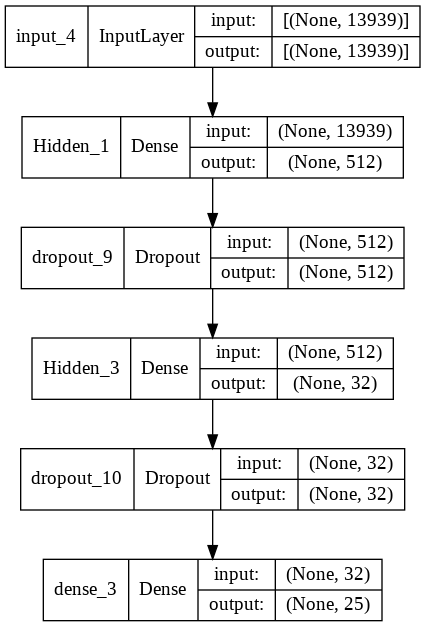

In [98]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [99]:
epochs = 100
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_nn, Y_tf_train_nn, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/100
10/10 [==============================] - 2s 96ms/step - loss: 0.6441 - accuracy: 0.0451 - val_loss: 0.5463 - val_accuracy: 0.0390
Epoch 2/100
10/10 [==============================] - 1s 74ms/step - loss: 0.4778 - accuracy: 0.0425 - val_loss: 0.3813 - val_accuracy: 0.0332
Epoch 3/100
10/10 [==============================] - 1s 75ms/step - loss: 0.3429 - accuracy: 0.0366 - val_loss: 0.2846 - val_accuracy: 0.0332
Epoch 4/100
10/10 [==============================] - 1s 74ms/step - loss: 0.2688 - accuracy: 0.0374 - val_loss: 0.2341 - val_accuracy: 0.0332
Epoch 5/100
10/10 [==============================] - 1s 75ms/step - loss: 0.2275 - accuracy: 0.0371 - val_loss: 0.2051 - val_accuracy: 0.0332
Epoch 6/100
10/10 [==============================] - 1s 73ms/step - loss: 0.2028 - accuracy: 0.0398 - val_loss: 0.1874 - val_accuracy: 0.0332
Epoch 7/100
10/10 [==============================] - 1s 74ms/step - loss: 0.1876 - accuracy: 0.0414 - val_loss: 0.1762 - val_accuracy: 0.0332
Epoch 

### TF-IDF Neural network - predict study program
tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program

In [99]:
tf_train_program_nn = tf_train_program.toarray()

In [100]:
print(tf_train_program_nn.shape)
print(Y_tf_train_program.shape)

(10394, 11069)
(10394, 483)


In [101]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(tf_train_program.shape[1], ))
x = Dense(1024, activation="relu", name='Hidden_1')(input)
x = Dropout(0.4)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
# x = Dropout(0.2)(x)
output = Dense(Y_tf_train_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

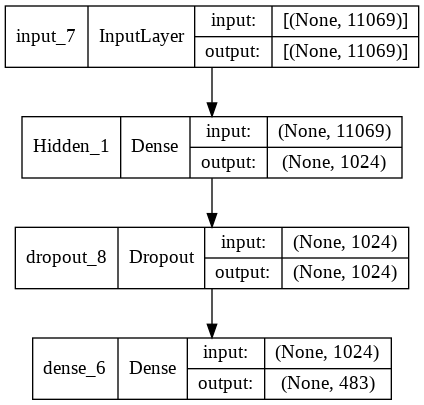

In [102]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [103]:
epochs = 10
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_program_nn, Y_tf_train_program, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 1s 163ms/step - loss: 0.5015 - accuracy: 0.0012 - val_loss: 0.0488 - val_accuracy: 9.6154e-04
Epoch 2/10
5/5 [==============================] - 0s 95ms/step - loss: 0.0316 - accuracy: 0.0045 - val_loss: 0.0379 - val_accuracy: 0.0260
Epoch 3/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0469 - accuracy: 0.0192 - val_loss: 0.0552 - val_accuracy: 0.0260
Epoch 4/10
5/5 [==============================] - 0s 86ms/step - loss: 0.0597 - accuracy: 0.0195 - val_loss: 0.0600 - val_accuracy: 0.0260
Epoch 5/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0612 - accuracy: 0.0195 - val_loss: 0.0565 - val_accuracy: 0.0183
Epoch 6/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0556 - accuracy: 0.0144 - val_loss: 0.0495 - val_accuracy: 0.0077
Epoch 7/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0472 - accuracy: 0.0067 - val_loss: 0.0416 - val_accuracy: 0.0202
Epoch 8/10
5/5 [======

### Thai2Fit Neural network - predict study program
t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program

In [82]:
# tf_train_program_nn = tf_train_program.toarray()

In [85]:
print(t2f_train_program.shape)
print(Y_t2f_test_program.shape)

(10394, 300)
(10394, 483)


In [120]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(t2f_train_program.shape[1], ))
# x = Dense(512, activation="relu", name='Hidden_1')(input)
# x = Dropout(0.1)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
x = Dropout(0.2)(input)
output = Dense(Y_t2f_test_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

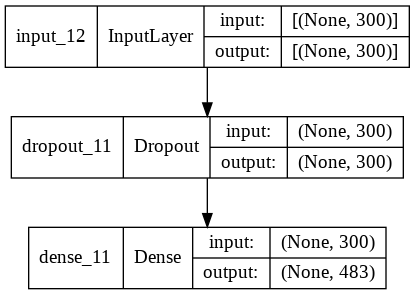

In [121]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [130]:
epochs = 100
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(t2f_train_program, Y_t2f_test_program, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
5/5 [==============================] - 0s 45ms/step - loss: 0.0107 - accuracy: 0.4845 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4833 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4886 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0106 - accuracy: 0.4917 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0106 - accuracy: 0.4897 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4912 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4882 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 8/100
5/5 [===

### LSTM
X_train, X_test, Y_train, Y_test

In [ ]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 2048

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)


Epoch 1/5
10/10 [==============================] - 31s 3s/step - loss: 3.1912 - accuracy: 0.1368 - val_loss: 3.1000 - val_accuracy: 0.1424
Epoch 2/5
10/10 [==============================] - 27s 3s/step - loss: 2.9711 - accuracy: 0.1215 - val_loss: 2.8760 - val_accuracy: 0.1282
Epoch 3/5
10/10 [==============================] - 26s 3s/step - loss: 2.8505 - accuracy: 0.1706 - val_loss: 2.8237 - val_accuracy: 0.2428
Epoch 4/5
10/10 [==============================] - 26s 3s/step - loss: 2.7846 - accuracy: 0.2376 - val_loss: 2.7396 - val_accuracy: 0.2823
Epoch 5/5
10/10 [==============================] - 26s 3s/step - loss: 2.6632 - accuracy: 0.2665 - val_loss: 2.5881 - val_accuracy: 0.2901


In [ ]:
epochs = 5
batch_size = 2048
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
epochs = 5
batch_size = 2048
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
epochs = 5
batch_size = 2048
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
epochs = 5
batch_size = 2048
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
epochs = 5
batch_size = 2048
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
model.evaluate(X_test, Y_test)

72/72 [==============================] - 9s 130ms/step - loss: 2.5346 - accuracy: 0.3001


[2.534619092941284, 0.3001316487789154]

In [ ]:
# model.save_weights('/content/drive/My Drive/model_chula_course.h5')

In [ ]:
for x in X_test[0]:
  if x != 0:
    key =  list(word_index.keys())[list(word_index.values()).index(x)]
    print(key, end='')

ทฤษฎีและแนวคิดของจิตบำบัดระหว่างบุคคลกระบวนการและเทคนิควิธีการบำบัดประสิทธิภาพของการบำบัดงานวิจัยที่เกี่ยวข้อง

In [ ]:
word_index

{'การ': 1,
 'และ': 2,
 'ของ': 3,
 'ใน': 4,
 'ที่': 5,
 'ทาง': 6,
 'วิเคราะห์': 7,
 'ใช้': 8,
 'ระบบ': 9,
 'กับ': 10,
 'ด้าน': 11,
 'เพื่อ': 12,
 'แบบ': 13,
 'เกี่ยวกับ': 14,
 'โดย': 15,
 'ต่างๆ': 16,
 'การศึกษา': 17,
 'ทฤษฎี': 18,
 'ออกแบบ': 19,
 'เชิง': 20,
 'หลักการ': 21,
 'มี': 22,
 'จาก': 23,
 'ข้อมูล': 24,
 'จัดการ': 25,
 'ปัญหา': 26,
 'การพัฒนา': 27,
 'เทคนิค': 28,
 'โรค': 29,
 'แนวคิด': 30,
 'ผู้ป่วย': 31,
 'เกี่ยวข้อง': 32,
 'ต่อ': 33,
 'สำหรับ': 34,
 'เป็น': 35,
 'ตรวจ': 36,
 'วิธี': 37,
 'การรักษา': 38,
 'พื้นฐาน': 39,
 'ความ': 40,
 'งาน': 41,
 'โครงสร้าง': 42,
 'กระบวนการ': 43,
 'การวิจัย': 44,
 'สังคม': 45,
 'ด้วย': 46,
 'วิธีการ': 47,
 'ระหว่าง': 48,
 'เน้น': 49,
 'ยา': 50,
 'สุขภาพ': 51,
 'หรือ': 52,
 'ฝึก': 53,
 'ให้': 54,
 'ความรู้': 55,
 'ผล': 56,
 'ทักษะ': 57,
 'ระดับ': 58,
 'หัวข้อ': 59,
 'ได้แก่': 60,
 'สร้าง': 61,
 'ภาษา': 62,
 'หลัก': 63,
 'ความสัมพันธ์': 64,
 'อย่าง': 65,
 'การควบคุม': 66,
 'ไทย': 67,
 'ทั้ง': 68,
 'จัด': 69,
 'ศึกษา': 70,
 'ประยุกต์': 71,
 'รูปแ

In [ ]:
model.predict(X_test[0].reshape(1, X_test.shape[1]))

array([[0.11992066, 0.12662609, 0.08689861, 0.10577508, 0.11633942,
        0.03984911, 0.04935289, 0.04230786, 0.04330821, 0.02770407,
        0.03404477, 0.02494375, 0.02583058, 0.03114584, 0.01621655,
        0.02273687, 0.01876359, 0.0194274 , 0.01702226, 0.01051345,
        0.00446881, 0.00441496, 0.00451487, 0.00370871, 0.00416559]],
      dtype=float32)

In [ ]:
enc.inverse_transform([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

array([[1]])

In [ ]:
word_index_y

{'20': 13,
 '21': 3,
 '22': 2,
 '23': 5,
 '24': 12,
 '25': 11,
 '26': 10,
 '27': 4,
 '28': 8,
 '29': 17,
 '30': 1,
 '31': 9,
 '32': 7,
 '33': 6,
 '34': 15,
 '35': 19,
 '36': 20,
 '37': 14,
 '38': 16,
 '39': 18,
 '40': 25,
 '51': 24,
 '53': 21,
 '55': 22,
 '63': 23}

In [ ]:
Y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])